## Imports & Settings

In [9]:
# Update working directory to parent so that we may use our custom functions
import os
os.chdir('..')
# os.getcwd( )

import pandas as pd
import itertools
import re
from ast import literal_eval
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np

## Load Test Data

In [2]:
# load test data
iSarcasm_df = pd.read_csv('data/target_semEval2022_en/iSarcasmEval-main/test/task_A_En_test.csv')
iSarcasm_df = iSarcasm_df.rename(columns={'tweet': 'text'})
iSarcasm_df = iSarcasm_df.rename(columns={'sarcastic': 'label'})

true_preds = iSarcasm_df['label'].to_list()

## Load Model Results Dataset

In [3]:
results_df = pd.read_csv('results/results_target.csv', converters={'predictions': pd.eval})

results_df.head()

,model_name,model_epoch,test_accuracy,test_f1,predictions
0,iSarcasm_control_01,E01_A0.61_F0.4,0.797143,0.128834,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,iSarcasm_control_01,E02_A0.83_F0.82,0.767143,0.402930,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,iSarcasm_control_01,E03_A0.87_F0.87,0.740000,0.403279,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ..."
3,iSarcasm_control_01,E04_A0.86_F0.87,0.693571,0.370044,"[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,iSarcasm_control_01,E05_A0.93_F0.93,0.822857,0.403846,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Filter Dataset
Below, we filter the dataset to retrieve only the best models by Accuracy score.

In [4]:
idx = results_df.groupby(['model_name'])['test_accuracy'].transform(max) == results_df['test_accuracy']

accuracy_estimators_df = results_df[idx]


patternDel = ".*control.*"
filter = accuracy_estimators_df['model_name'].str.contains(patternDel)

accuracy_estimators_df = accuracy_estimators_df[~filter]
accuracy_estimators_df

,model_name,model_epoch,test_accuracy,test_f1,predictions
36,target-iSarcasm_inter-XED-binary_01,E07_A0.93_F0.93,0.850714,0.424242,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
43,target-iSarcasm_inter-XED-binary_02,E04_A0.91_F0.9,0.835000,0.426799,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
54,target-iSarcasm_inter-XED-binary_03,E05_A0.91_F0.91,0.795714,0.430279,"[0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
66,target-iSarcasm_inter-SARC_01,E07_A0.92_F0.91,0.833571,0.492375,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
74,target-iSarcasm_inter-SARC_02,E05_A0.9_F0.9,0.806429,0.465483,"[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, ..."
83,target-iSarcasm_inter-SARC_03,E04_A0.9_F0.9,0.802143,0.438134,"[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
99,target-iSarcasm_inter-XED-fine_01,E10_A0.94_F0.93,0.828571,0.402985,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
109,target-iSarcasm_inter-XED-fine_02,E10_A0.91_F0.91,0.802143,0.419287,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
119,target-iSarcasm_inter-XED-fine_03,E10_A0.91_F0.91,0.810000,0.357488,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
127,target-iSarcasm_inter-IMDB_01,E08_A0.92_F0.92,0.792857,0.334862,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


## Self-Select Estimators

In [14]:
# use all estimators 
# estimators = estimators_df['model_name'].to_list()

# define particular estimators 
estimators = ['target-iSarcasm_inter-XED-binary_01', 'target-iSarcasm_inter-XED-binary_02', 'target-iSarcasm_inter-XED-binary_03','target-iSarcasm_inter-SARC_01', 'target-iSarcasm_inter-SARC_02', 'target-iSarcasm_inter-SARC_03','target-iSarcasm_inter-hellaswag_01', 'target-iSarcasm_inter-hellaswag_02', 'target-iSarcasm_inter-hellaswag_03']

# get predictions of the defined estimators
predictions =  [accuracy_estimators_df.loc[accuracy_estimators_df['model_name']==m, 'predictions'].tolist()[0] for m in estimators]

print(estimators)
print(len(predictions))


['target-iSarcasm_inter-XED-binary_01', 'target-iSarcasm_inter-XED-binary_02', 'target-iSarcasm_inter-XED-binary_03', 'target-iSarcasm_inter-SARC_01', 'target-iSarcasm_inter-SARC_02', 'target-iSarcasm_inter-SARC_03', 'target-iSarcasm_inter-hellaswag_01', 'target-iSarcasm_inter-hellaswag_02', 'target-iSarcasm_inter-hellaswag_03']
9


In [15]:
pred_groups = []
for i in range(len(true_preds)):
    pred_stage = []
    for prediction in predictions:
        pred_stage.append(prediction[i])
    pred_groups.append(pred_stage)

# print(pred_groups[0])
# print(pred_groups[1])
# print(pred_groups[2])
# print(pred_groups[3])
# print(pred_groups[4])



In [16]:
for i in range(20):    
    pred_index = i
    the_list = pred_groups[pred_index]
    prediction = max(set(the_list), key=the_list.count)

    if prediction == true_preds[pred_index]:
        print(prediction, true_preds[pred_index])
    else:
        print(prediction, true_preds[pred_index], iSarcasm_df['text'].iloc[i])

0 0
1 0 Pinball!
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 1 Sometimes I lay in bed and think about how today will be the day I make my life better. Exercise, drinking water, eating healthy. Then I wake up. 
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [7]:
def most_common(lst):
    return max(set(lst), key=lst.count)


In [ ]:

ensemble_preds = []

for i in pred_groups:
    ensemble_preds.append(most_common(i))
# print(ensemble_preds)

In [18]:

acc = accuracy_score(true_preds, ensemble_preds)
f1 = f1_score(true_preds, ensemble_preds, average='binary')

print(acc)
print(f1)

0.8442857142857143
0.4906542056074767


# Try All Estimator Combinations

In [5]:
estimators = accuracy_estimators_df['model_name'].to_list()

# estimators = [1, 3, 3]
combinations = []
for r in range(len(estimators)+1):
    for combination in itertools.combinations(set(estimators), r):
        combinations.append(combination)

three_estimators = []
for i in combinations:
    if len(i) == 3: 
        three_estimators.append(i)

print(three_estimators[0])

('target-iSarcasm_inter-IMDB_03', 'target-iSarcasm_inter-XED-binary_02', 'target-iSarcasm_inter-hellaswag_01')


In [10]:
accuracies = []
f1s = []

for i in three_estimators:
    predictions = [accuracy_estimators_df.loc[accuracy_estimators_df['model_name']==m, 'predictions'].tolist()[0] for m in i]

    pred_groups = []
    for j in range(len(true_preds)):
        pred_stage = []
        for prediction in predictions:
            pred_stage.append(prediction[j])
        pred_groups.append(pred_stage)

    ensemble_preds = []
    for k in pred_groups:
        ensemble_preds.append(most_common(k))
    
    acc = accuracy_score(true_preds, ensemble_preds)
    f1 = f1_score(true_preds, ensemble_preds, average='binary')
    accuracies.append(acc)
    f1s.append(f1)
    # print(acc, f1)

In [14]:
print(max(accuracies))
acc_max_idx = np.argmax(accuracies) 
print(f1s[acc_max_idx])

0.8735714285714286
0.44514106583072094


In [17]:
print(max(f1s))
f1_max_idx = np.argmax(f1s) 
print(accuracies[f1_max_idx])

0.5011600928074246
0.8464285714285714


In [25]:
values, counts = np.unique(accuracies, return_counts=True)

print(len(accuracies))
print(values)
print(counts)

455
[0.81142857 0.81571429 0.81785714 0.81857143 0.81928571 0.82
 0.82071429 0.82142857 0.82214286 0.82285714 0.82357143 0.82428571
 0.825      0.82642857 0.82714286 0.82785714 0.82857143 0.82928571
 0.83       0.83071429 0.83142857 0.83214286 0.83285714 0.83357143
 0.83428571 0.835      0.83571429 0.83642857 0.83714286 0.83785714
 0.83857143 0.83928571 0.84       0.84071429 0.84142857 0.84214286
 0.84285714 0.84357143 0.84428571 0.845      0.84571429 0.84642857
 0.84714286 0.84785714 0.84857143 0.84928571 0.85       0.85071429
 0.85142857 0.85214286 0.85285714 0.85357143 0.85428571 0.855
 0.85571429 0.85642857 0.85714286 0.85785714 0.85857143 0.85928571
 0.86       0.86071429 0.86142857 0.86214286 0.86285714 0.86357143
 0.86428571 0.865      0.86571429 0.86642857 0.86714286 0.86785714
 0.86857143 0.86928571 0.87       0.87071429 0.87142857 0.87214286
 0.87357143]
[ 1  1  2  2  2  1  3  3  5  3  2  4  2  6  4  6  5  3  1 10  4  6 10  4
  7  4  8  4  4  9  2  4 10  9  6  7  7  8  3  8  

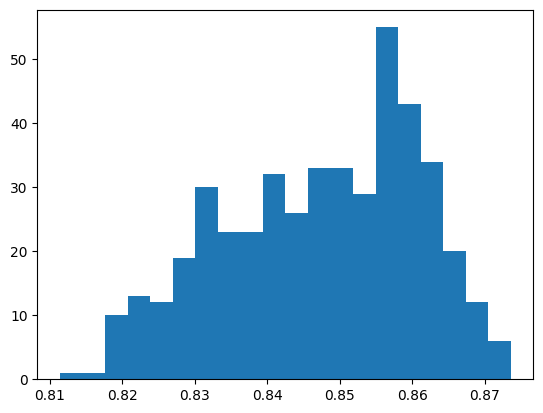

In [24]:
import matplotlib.pyplot as plt

plt.hist(accuracies, bins=20)
plt.show() 

# NOTES: See if we can plot/visualize ensemble scores to see if they regularly outperform our control and intermetaely fine-tuned models

# ALSO, COUNT PREVELANCE OF EACH MODEL CONTRIBUTING TO ENSEMBELS THAT OUTPERFORM BEST INDIVIDUAL MODELS AT EACH METRIC. SEE IF THERE IS A COORELATION BETWEEEN BEST INDIVIDUAL MODELS AND BIGGEST CONTRIBUTORS OF BEST ENSEMBLES